In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.dummy import DummyClassifier

In [3]:
import sys
sys.path.append('../../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

Using TensorFlow backend.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/w

# Model Comparison

In [4]:
metrics=['roc_auc', 'accuracy', 'precision', 'recall']

## Load Data

In [5]:
ip_address = '18.218.116.177'
_, normal_data = fetch_model_data.fetch_model_data(ip_address, split=True)

In [6]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

In [7]:
X, y = normal_data[first_feature_set], normal_data.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

## Run Models

In [8]:
models = [
    ('dummy', {}, DummyClassifier),
    ('knn', { 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}, KNeighborsClassifier),
    ('log', { 'C': [x/10 for x in range(1, 11)], 'penalty': ['l1', 'l2']}, LogisticRegression),
    ('bNB', {}, BernoulliNB),
    ('rf', {
        'n_estimators': [100],
        'max_depth': range(3, 20),
        'min_samples_leaf': range(2, 25)
    }, RandomForestClassifier),
    ('svm', {
#         'penalty': ['l1', 'l2'],
#         'loss': ['hinged', 'squared_hinge'],
        'C': [x/10 for x in range(1, 11)],
        'random_state': [99]
    }, LinearSVC),
    ('dt', { 'max_depth': range(3, 20), 'min_samples_leaf': range(2, 15) }, DecisionTreeClassifier),
    ('stupid_dt', {'max_depth': [2, 5], 'min_samples_leaf': range(10, 20), 'min_impurity_decrease': [0.01]}, DecisionTreeClassifier),
]

In [9]:
%%capture
results, info = evaluation.comparison_pipeline(X_train, y_train, models, metrics)

In [13]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]

In [14]:
results

,roc_auc,accuracy,precision,recall
dummy,0.497225,0.733035,0.848211,0.833253
knn,0.604049,0.844587,0.844587,1.000000
log,0.637132,0.841645,0.846197,0.993043
bNB,0.549963,0.844587,0.844587,1.000000
rf,0.661216,0.844587,0.844587,1.000000
svm,NaN,0.841645,0.847217,0.991304
dt,0.599994,0.818244,0.855579,0.944468
stupid_dt,0.545121,0.844587,0.844587,1.000000


In [15]:
rf_params = info[4]['best_params']

In [16]:
rf_params

{'max_depth': 3, 'min_samples_leaf': 22, 'n_estimators': 100}

## Random Forest

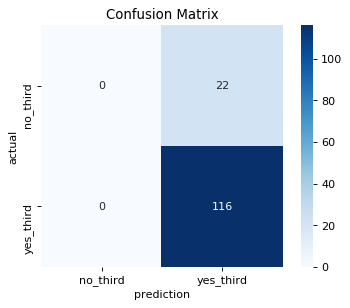

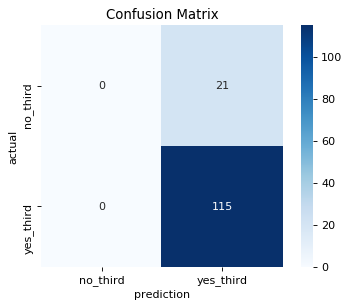

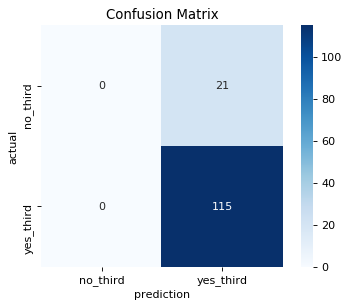

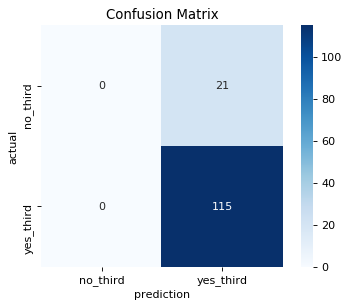

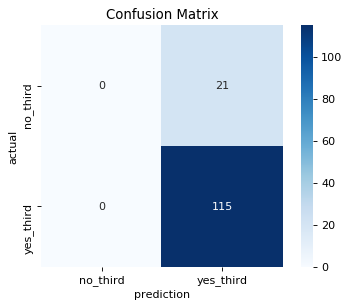

In [21]:
scores_rf = evaluation.cross_validate(
    RandomForestClassifier,
    X_train,
    y_train,
    fit_params=rf_params,
    scoring=metrics,
#     standardize=False,
#     oversample=True,
    show_conf_matrices=True
)

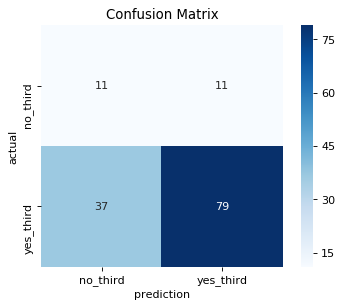

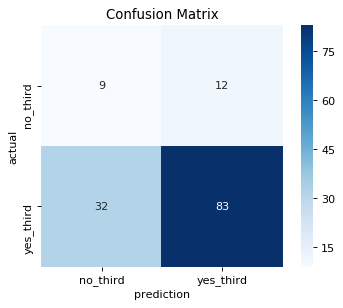

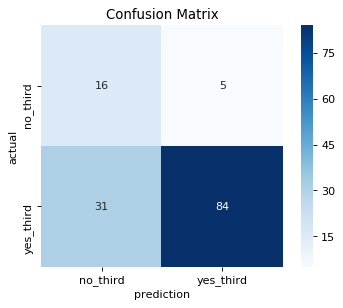

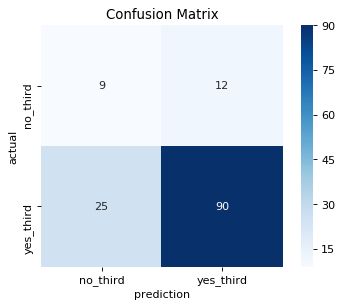

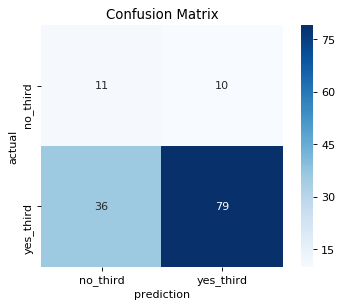

In [20]:
scores_rf_os = evaluation.cross_validate(
    RandomForestClassifier,
    X_train,
    y_train,
    fit_params=rf_params,
    scoring=metrics,
#     standardize=False,
    oversample=True,
    show_conf_matrices=True
)

In [23]:
evaluation.report_single_model_metrics(scores_rf_os, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.664041,0.051590,0.803356
1,accuracy,0.690729,0.034350,0.731340
2,precision,0.893055,0.025805,0.720213
3,recall,0.720555,0.036443,0.759969


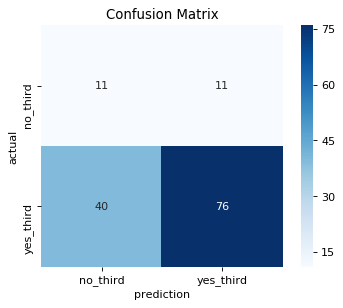

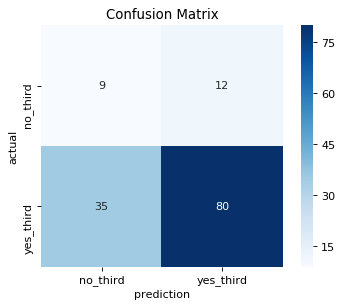

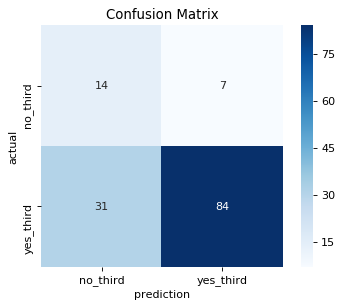

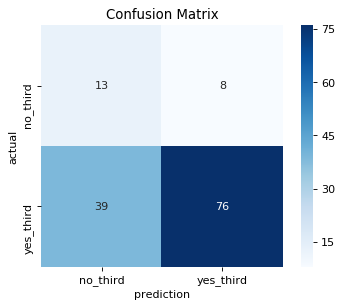

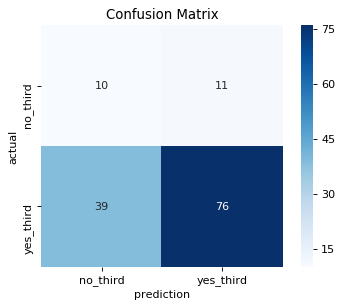

In [53]:
overfit_features = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
#     'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
#     'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
]

scores_rf_os = evaluation.cross_validate(
    RandomForestClassifier,
    X_train[overfit_features],
    y_train,
    fit_params={'max_depth': 3, 'min_samples_leaf': 22, 'n_estimators': 200},
    scoring=metrics,
#     standardize=False,
    oversample=True,
    show_conf_matrices=True
)

In [54]:
evaluation.report_single_model_metrics(scores_rf_os, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.642582,0.053216,0.792823
1,accuracy,0.658440,0.032740,0.709207
2,precision,0.888906,0.021279,0.705242
3,recall,0.680600,0.028758,0.719610


In [55]:
rf = scores_rf_os['estimators'][0]

In [56]:
len(rf.estimators_)

200

In [58]:
for n, f in zip(overfit_features, rf.feature_importances_):
    print(n, f)

author_ideology 0.11307644207980083
author_party 0.011070389521107615
author_is_chair 0.00442853254589938
author_years_sen 0.07192653188563063
total_sponsors 0.019267722792810596
sponsor_chairs 0.021529426762923548
agg_exp_sponsors 0.049565954978354816
total_slips 0.29509752128458633
slips_perc_pro 0.3357725338876882
bipartisan 0.004547465567834019
ideol_range 0.07371747869336397


## Tree Exploration

In [64]:
print(export_text(rf.estimators_[0], feature_names=overfit_features))

|--- total_slips <= 5.50
|   |--- author_party <= 1.50
|   |   |--- agg_exp_sponsors <= 15.50
|   |   |   |--- class: 1.0
|   |   |--- agg_exp_sponsors >  15.50
|   |   |   |--- class: 1.0
|   |--- author_party >  1.50
|   |   |--- slips_perc_pro <= 0.55
|   |   |   |--- class: 0.0
|   |   |--- slips_perc_pro >  0.55
|   |   |   |--- class: 1.0
|--- total_slips >  5.50
|   |--- author_years_sen <= 13.50
|   |   |--- ideol_range <= 0.29
|   |   |   |--- class: 0.0
|   |   |--- ideol_range >  0.29
|   |   |   |--- class: 1.0
|   |--- author_years_sen >  13.50
|   |   |--- total_slips <= 129.00
|   |   |   |--- class: 0.0
|   |   |--- total_slips >  129.00
|   |   |   |--- class: 0.0



In [37]:
# everything fails that doesn't have unanimous community support and is from a non-crazy conservative
# arbitrary funding cut-off (3.1 mil)
# another arbitrary funding cut-off (.5 mil), also (2.3 mil)

In [ ]:
# ideas
    # maybe bucket funding levels
    # unanimous flag
    

# What if I oversample

## Decision Tree

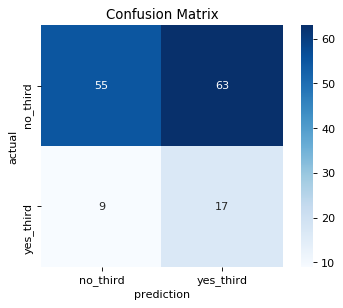

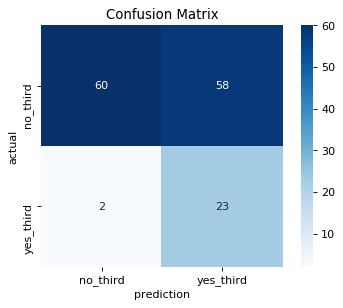

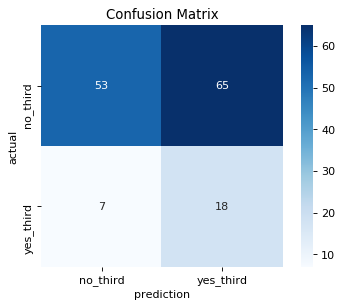

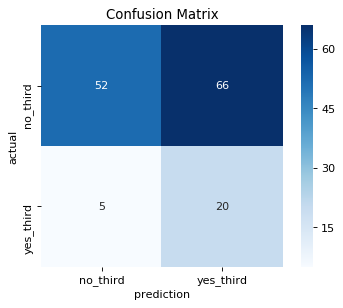

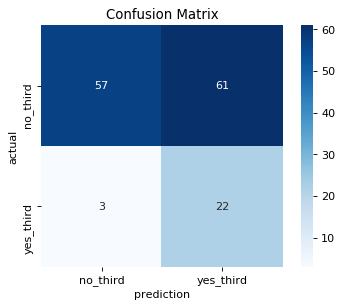

In [104]:
scores_dt_os = evaluation.cross_validate(
    DecisionTreeClassifier,
    X_train,
    y_train,
    fit_params=dt_params,
    scoring=metrics,
    standardize=False,
    oversample=True,
    show_conf_matrices=True
)

In [105]:
evaluation.report_single_model_metrics(scores_dt_os, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.646821,0.057759,0.659981
1,accuracy,0.526573,0.033799,0.636653
2,precision,0.242187,0.027866,0.601952
3,recall,0.794769,0.098412,0.805085


## Logistic

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

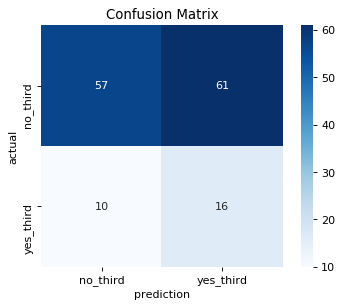

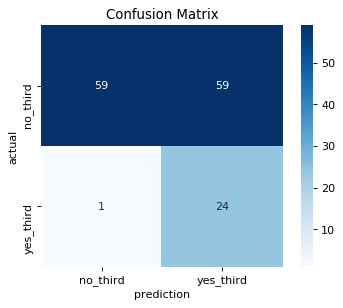

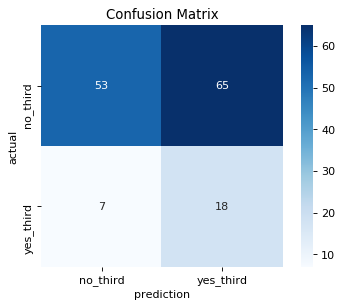

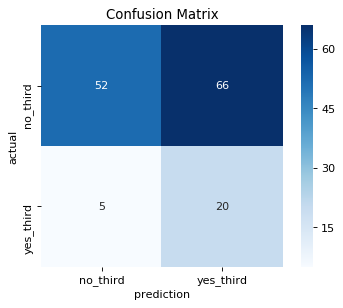

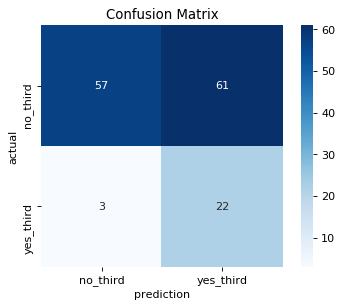

In [101]:
scores_log_os = evaluation.cross_validate(
    LogisticRegression,
    X_train,
    y_train,
    fit_params=logit_params,
    scoring=metrics,
    standardize=True,
    oversample=True,
    show_conf_matrices=True
)

In [102]:
evaluation.report_single_model_metrics(scores_log_os, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.658035,0.066929,0.657277
1,accuracy,0.527962,0.032806,0.634110
2,precision,0.242287,0.030483,0.600711
3,recall,0.795077,0.120301,0.798305


In [ ]:
# Predicting like .27 for a whole bunch of them
    # Threshold doesn't tune anything until going from 0.3 -> 0.2
    # Basically switch from not-ovesampled (6% recall, 90% precision) to
        # oversampled (54% accuracy, 24% precision, 80% recall)